# Multiprocessing using Pools 
A simple framework for assessing the impact of multiprocessing on runtime on a multi-core machine. 

In [1]:
import time
import math
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt

# A function for timing a job that uses a pool of processes.
#  f is a function that takes a single argument
#  data is an array of arguments on which f will be mapped
#  pool_size is the number of processes in the pool. 
def pool_process(f, data, pool_size):
    tp1 = time.time()
    pool = Pool(processes=pool_size) # initialize the Pool.
    result = pool.map(f, data)       # map f to the data using the Pool of processes to do the work 
    pool.close() # No more processes
    pool.join()  # Wait for the pool processing to complete. 
    
    return int(time.time()-tp1)
 

## Load Target function separately 
The target function needs to be loaded in from a separate python file.
So save this function declaration in a file miscFunc.py

    import math

    def my_func(x):  
        s = math.sqrt(x)  
        return s
    

In [2]:
import miscFunc as miscFunc # if miscFunc.py is changed the kernel needs to be restarted. 

This verbose version shows which process in the pool is running each task.   
Put this definition in miscFunc.py as well.  

    def my_func_verbose(x):
        s = math.sqrt(x)
        print("Task", multiprocessing.current_process(), x, s)
        return s

In [3]:
dataRange = range(20)

Use the pool_process function to apply my_func to the data in dataRange.  
This task is so light it requires very little processing time. 

In [4]:
dataRange = range(10)
pool_process(miscFunc.my_func, dataRange, 1)

0

## A naive function for checking primes 

In [5]:
check_work = [45,13,4]

In [6]:
pool_process(miscFunc.my_func_verbose, check_work, 1)

Task <ForkProcess(ForkPoolWorker-2, started daemon)> 45 6.708203932499369
Task <ForkProcess(ForkPoolWorker-2, started daemon)> 13 3.605551275463989
Task <ForkProcess(ForkPoolWorker-2, started daemon)> 4 2.0


0

In [7]:
prime_data =[]
file = open("primes.txt","r")
for line in file:
    line = line.split()
    for number in line:
        prime_data.append(int(number))

In [8]:
result = pool_process(miscFunc.check_prime, prime_data, 4)
result

62

**Running tests**

In [9]:
ncores = 6
cores = []
times = []
    
"""Run through number of available cores and test time taken"""
for nc in range(1,ncores+1):
    cores.append(nc)
    times.append(pool_process(miscFunc.check_prime, prime_data, nc))

**Fitting functions**

In [10]:
from scipy.optimize import curve_fit
import numpy as np

def fitting_function(cores,a,b,c):
    return a*np.exp(-b*cores) + c

p, c = curve_fit(fitting_function, cores, times)

fitted_cores = np.linspace(1,6,100)
fitted_times = fitting_function(fitted_cores, *p)

**Plotting**

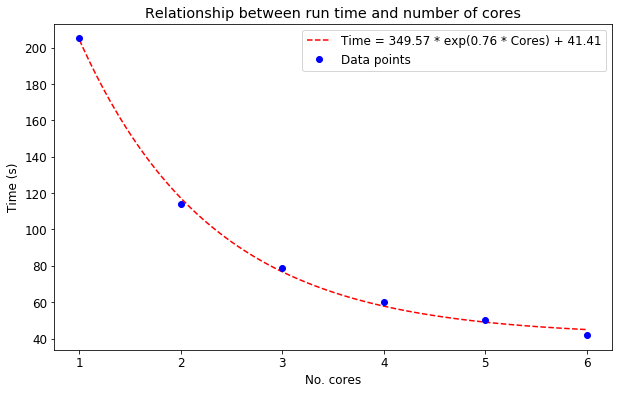

In [11]:
plt.rc('font',size=12)
plt.figure(figsize=(10,6))
plt.title("Relationship between run time and number of cores")
plt.xlabel('No. cores')
plt.ylabel('Time (s)')

plt.plot(fitted_cores, 
         fitted_times,
         'r--', 
         label = r"Time = %0.2f * exp(%0.2f * Cores) + %0.2f" % (p[0],p[1],p[2])
)

plt.plot(cores,
         times, 
         'bo', 
         label='Data points'
)
plt.legend(loc='best')
plt.savefig('TIMEvCORES_VM.png')

**Testing changing number of samples**

In [ ]:
"""vary number of processes (only go from 2 cores up to save time)"""

ncores = 6
vcores = []
vtimes = []
    
"""Run through number of available cores and test time taken"""
for vnc in range(2,ncores+1):
    tempcores = []
    temptimes = []
    for data in [prime_data[:100000], prime_data[:500000], prime_data]:
        tempcores.append(vnc)
        temptimes.append(pool_process(miscFunc.check_prime, data, vnc))
    vcores.append(tempcores)
    vtimes.append(temptimes)

In [76]:
vcores_test = []

for col in range(len(vcores[0])):
    temp_holder = []
    for row in vcores:
        temp_holder.append(row[col])
    vcores_test.append(temp_holder)
vcores_test

[[2, 3, 4, 5, 6], [2, 3, 4, 5, 6], [2, 3, 4, 5, 6]]

In [79]:
vtimes_test = []
for col in range(len(vtimes[0])):
    temp_holder = []
    for row in vtimes:
        temp_holder.append(row[col])
    vtimes_test.append(temp_holder)
vtimes_test

[[112, 78, 59, 48, 41], [109, 78, 58, 48, 42], [110, 78, 59, 50, 42]]

In [85]:
ps = []
fitted_cores_t = []
fitted_times_t = []

for idx in range(len(vtimes_test)):
    
    pcores = vcores_test[idx]
    ptimes = vtimes_test[idx]
    
    print(pcores, ptimes)
    
    pt, ct = curve_fit(fitting_function, pcores, ptimes)
    
    ps.append(pt)
    fitted_cores_t.append(np.linspace(1,6,100))
    fitted_times_t.append(fitting_function(fitted_cores_t[idx], *pt))

[2, 3, 4, 5, 6] [112, 78, 59, 48, 41]
[2, 3, 4, 5, 6] [109, 78, 58, 48, 42]
[2, 3, 4, 5, 6] [110, 78, 59, 50, 42]


/home/ciaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


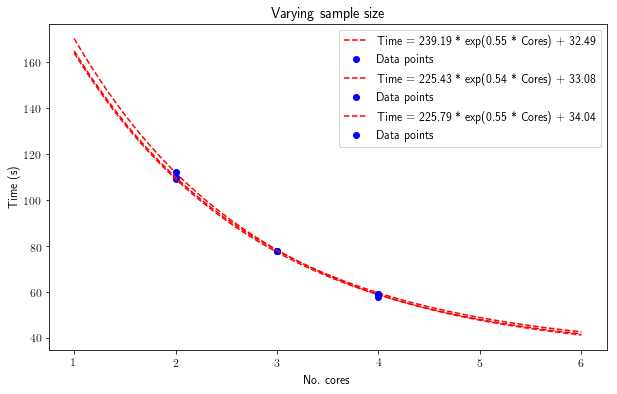

In [101]:
plt.rc('font',size=12)
plt.figure(figsize=(10,6))
plt.title("Varying sample size")
plt.xlabel('No. cores')
plt.ylabel('Time (s)')

sizes = [1000,
         5000, 
         10000
        ]

for index in range(len(vcores_test)):

    cores_temp = vcores[index]
    times_temp = vtimes[index]
    fitted_cores_temp = fitted_cores_t[index]
    fitted_times_temp = fitted_times_t[index]
    size = sizes[index]
    p = ps[index]
    
    plt.plot(fitted_cores_temp, 
             fitted_times_temp,
             'r--', 
             label = "Time = %0.2f * exp(%0.2f * Cores) + %0.2f" % (p[0],p[1],p[2])
    )

    plt.plot(cores_temp,
             times_temp, 
             'bo', 
             label= 'Data points: {}'.format(size)
    )

plt.legend(loc='best')
plt.savefig('VariedSamples.png')